In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Load dataset

from google.colab import files
uploaded = files.upload()

df = pd.read_csv("train.tsv", sep="\t")
print("Shape:", df.shape)

Saving train.tsv to train.tsv
Shape: (1482535, 8)


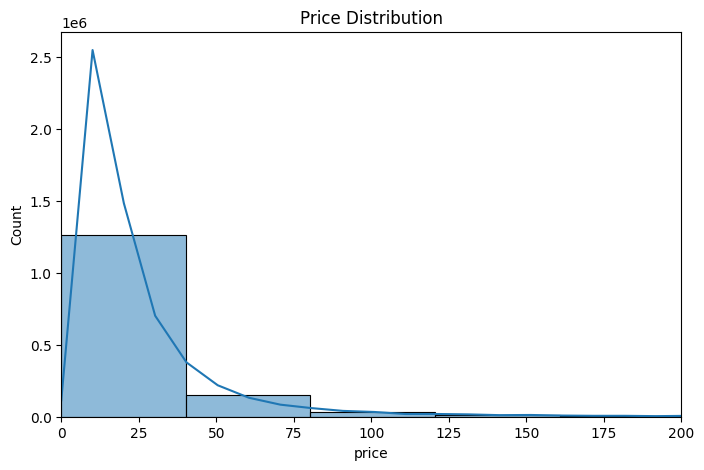

Missing values per column:
 train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          6
dtype: int64


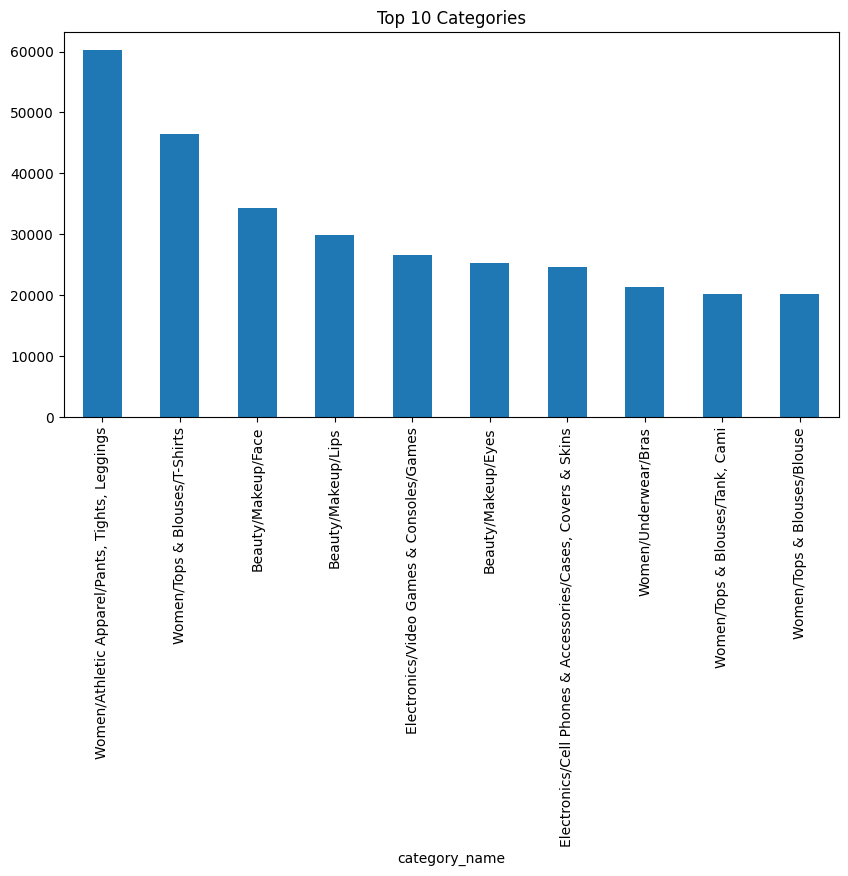

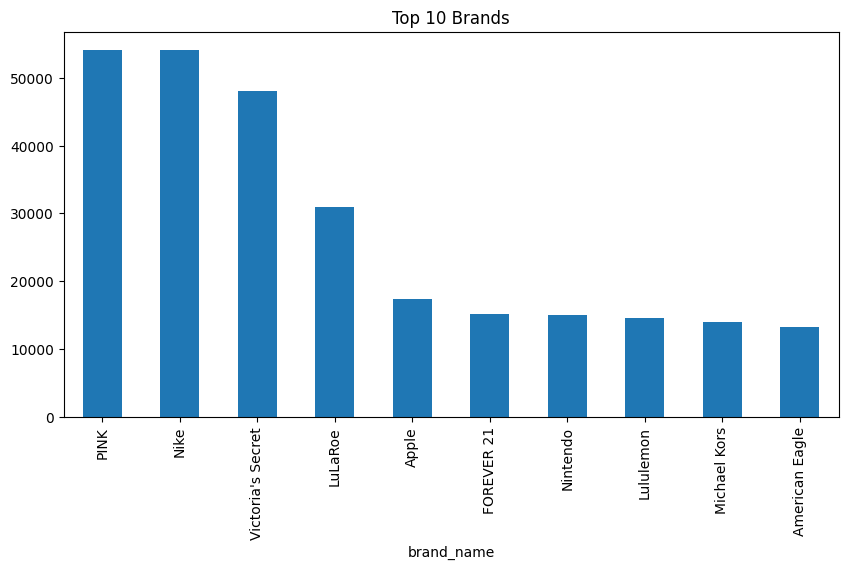

In [ ]:
# Exploratory Data Analysis (EDA)

plt.figure(figsize=(8,5))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlim(0, 200)
plt.show()

print("Missing values per column:\n", df.isnull().sum())

plt.figure(figsize=(10,5))
df["category_name"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Categories")
plt.show()

plt.figure(figsize=(10,5))
df["brand_name"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Brands")
plt.show()

In [ ]:
# cleaning and Imputation

df['category_name'] = df['category_name'].fillna("missing")
df['brand_name'] = df['brand_name'].fillna("missing")
df['item_description'] = df['item_description'].fillna("No description")
df['name'] = df['name'].fillna("missing")

def split_cat(text):
    try:
        return text.split("/")
    except:
        return ("missing", "missing", "missing")

df['cat1'], df['cat2'], df['cat3'] = zip(*df['category_name'].map(split_cat))

df = df[df['price'] > 0].copy()
df["target"] = np.log1p(df["price"])

In [ ]:
#feature engineering/ vectorization

# Name TF-IDF
tfidf_name = TfidfVectorizer(max_features=5000)
X_name = tfidf_name.fit_transform(df["name"])

# Description TF-IDF
tfidf_desc = TfidfVectorizer(max_features=10000, stop_words="english")
X_desc = tfidf_desc.fit_transform(df["item_description"])

# Category TF-IDF
tfidf_cat = TfidfVectorizer()
X_cat = tfidf_cat.fit_transform(df["category_name"])

# Label Encoding for categorical features
le_brand = LabelEncoder()
df['brand_encoded'] = le_brand.fit_transform(df['brand_name'])
X_brand = df['brand_encoded'].values.reshape(-1, 1)

le_item_cond = LabelEncoder()
df['item_condition_encoded'] = le_item_cond.fit_transform(df['item_condition_id'])
X_item_cond = df['item_condition_encoded'].values.reshape(-1, 1)

# Combine all features
X = hstack((X_name, X_desc, X_cat, X_brand, X_item_cond))
y = df["target"].values

del X_name, X_desc, X_cat, X_brand, X_item_cond
gc.collect()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

Shape of DataFrame after removing zero-price items: (1481661, 14)

Missing values after imputation:
 train_id                  0
name                      0
item_condition_id         0
category_name             0
brand_name                0
price                     0
shipping                  0
item_description          0
cat1                      0
cat2                      0
cat3                      0
target                    0
brand_encoded             0
item_condition_encoded    0
dtype: int64

Top 10 brands after imputation:
 brand_name
Unknown              632336
PINK                  54072
Nike                  54006
Victoria's Secret     48011
LuLaRoe               30995
Apple                 17314
FOREVER 21            15178
Nintendo              14998
Lululemon             14550
Michael Kors          13916
Name: count, dtype: int64

Top 10 categories after imputation:
 category_name
Women/Athletic Apparel/Pants, Tights, Leggings                 60152
Women/Tops & Blouses/T

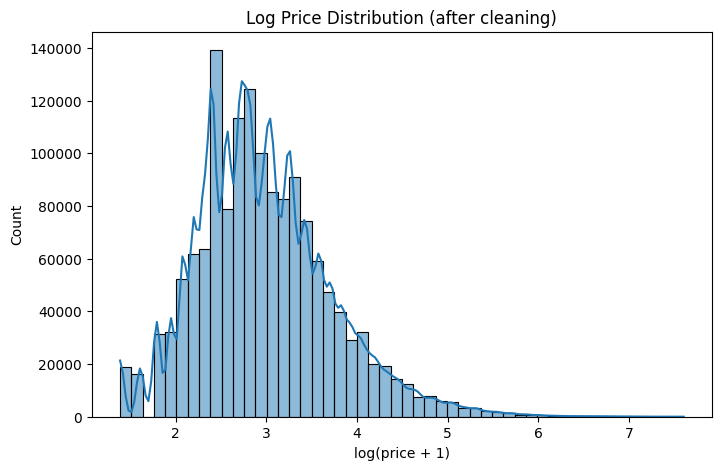

In [ ]:
# Summary after Cleaning & Imputation

# Check the shape of the DataFrame after removing price 0
print("Shape of DataFrame after removing zero-price items:", df.shape)

# Check for missing values again
print("\nMissing values after imputation:\n", df.isnull().sum())

# Display value counts for brand_name to confirm 'missing' has been added
print("\nTop 10 brands after imputation:\n", df['brand_name'].value_counts().head(10))

# Display value counts for category_name to confirm 'missing' has been added
print("\nTop 10 categories after imputation:\n", df['category_name'].value_counts().head(10))

# Visualize the price distribution again after removing zero-price items and applying log transform
plt.figure(figsize=(8,5))
sns.histplot(df["target"], bins=50, kde=True)
plt.title("Log Price Distribution (after cleaning)")
plt.xlabel("log(price + 1)")
plt.show()

In [ ]:

# 6. Model Training & Comparison

results = {}

# Ridge Regression
print("Training Ridge...")
ridge = Ridge(solver="sag", fit_intercept=True, random_state=42)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_valid)
results["Ridge"] = np.sqrt(mean_squared_error(y_valid, ridge_pred))

# LightGBM
import lightgbm as lgb
print("Training LightGBM...")
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting": "gbdt",
    "num_leaves": 64,
    "learning_rate": 0.1,
    "feature_fraction": 0.9
}

lgb_model = lgb.train(
    params,
    d_train,
    num_boost_round=1000,
    valid_sets=[d_valid],
    callbacks=[lgb.early_stopping(50, verbose=100)]
)
lgb_pred = lgb_model.predict(X_valid)
results["LightGBM"] = np.sqrt(mean_squared_error(y_valid, lgb_pred))

# XGBoost
import xgboost as xgb
print("Training XGBoost...")
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

xgb_model = xgb.train(
    params={"objective":"reg:squarederror", "eval_metric":"rmse"},
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dvalid, "valid")],
    early_stopping_rounds=50,
    verbose_eval=100
)
xgb_pred = xgb_model.predict(dvalid)
results["XGBoost"] = np.sqrt(mean_squared_error(y_valid, xgb_pred))

Training Ridge...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 225.320076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 597956
[LightGBM] [Info] Number of data points in the train set: 1185328, number of used features: 7799
[LightGBM] [Info] Start training from score 2.981011
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.48295
Training XGBoost...
[0]	valid-rmse:0.71463
[100]	valid-rmse:0.54581
[200]	valid-rmse:0.52522
[300]	valid-rmse:0.51473
[400]	valid-rmse:0.50757
[500]	valid-rmse:0.50274
[600]	valid-rmse:0.49891
[700]	valid-rmse:0.49598
[800]	valid-rmse:0.49365
[900]	valid-rmse:0.49180
[999]	valid-rmse:0.48996



Model Performance (RMSE):
Ridge: 0.5216
LightGBM: 0.4830
XGBoost: 0.4900


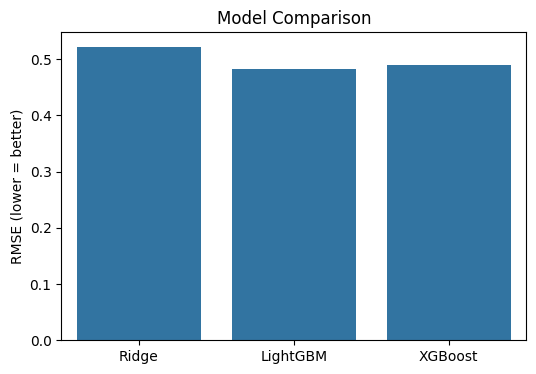

In [ ]:
# 7. Results Summary

print("\nModel Performance (RMSE):")
for model, score in results.items():
    print(f"{model}: {score:.4f}")

plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel("RMSE (lower = better)")
plt.title("Model Comparison")
plt.show()

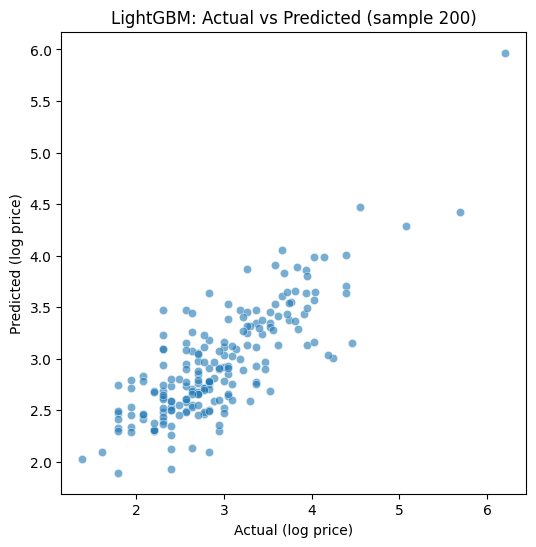

In [ ]:
# 8. Predictions Visualization

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_valid[:200], y=lgb_pred[:200], alpha=0.6)
plt.xlabel("Actual (log price)")
plt.ylabel("Predicted (log price)")
plt.title("LightGBM: Actual vs Predicted (sample 200)")
plt.show()
